In [ ]:
// %install '.package(path: "$cwd/FastaiNotebook_03_minibatch_training")' FastaiNotebook_03_minibatch_training
%install '.package(path: "$cwd/FastaiNotebook_04_callbacks")' FastaiNotebook_04_callbacks

In [ ]:
let IMAGENETTE_URL = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette.tgz"
let IMAGENETTE_160_URL = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160.tgz"
let IMAGENETTE_320_URL = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette-320.tgz"
let IMAGENETTE_FILE = "imagenette.tgz"

// First let us download the dataset. 
func downloadImagenetteData(_ url: String, _ filename: String) -> String {
    let urllib = Python.import("urllib.request")
    let downloadResult = urllib.urlretrieve(url, filename)
    print("\(downloadResult[0])")
    return String(downloadResult[0])!
}

//downloadImagenetteData(IMAGENETTE_160_URL, IMAGENETTE_FILE)
subprocess.run(["wget", IMAGENETTE_160_URL])
subprocess.run(["tar", "-xzvf", "imagenette-160.tgz"])
subprocess.run(["ls"])

In [ ]:
// Create a list of files
subprocess.run(["find", "imagenette-160/train", "-name", "*.JPEG", "-fprint", "imagenette-train-files.txt"])
subprocess.run(["find", "imagenette-160/val", "-name", "*.JPEG", "-fprint", "imagenette-val-files.txt"])
subprocess.run(["ls"])

In [1]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

import TensorFlow
import Python
//import Foundation

let subprocess = Python.import("subprocess")
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")


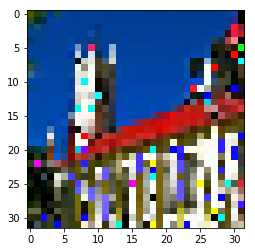

None


In [2]:
// Utility to resize an image!
func resizeImage(filename: StringTensor) -> Tensor<Float> {
    let imageBytes: StringTensor = Raw.readFile(filename: filename)
    let decodedImage = Raw.decodeJpeg(contents: imageBytes, channels: 3, dctMethod: "") 
    let resizedImages = Raw.resizeBicubic(
        images: Tensor<UInt8>([decodedImage]), 
        size: Tensor<Int32>([32, 32]))
    return resizedImages.reshaped(to: TensorShape(32, 32, 3))
//    return Raw.cast(resizedImage)
}

let resizedImage = resizeImage(filename: StringTensor("imagenette-160/val/n03028079/ILSVRC2012_val_00003682.JPEG"))
let npa = resizedImage.makeNumpyArray().astype(np.uint8)
plt.imshow(npa) 
plt.show()


In [3]:
// Some sample data to quickly test things!
let sampleValFiles: [String] = [
    "imagenette-160/val/n03028079/ILSVRC2012_val_00034021.JPEG",
    "imagenette-160/val/n03028079/ILSVRC2012_val_00026451.JPEG",
    "imagenette-160/val/n03028079/ILSVRC2012_val_00006268.JPEG",
    "imagenette-160/val/n03028079/ILSVRC2012_val_00004912.JPEG",
    "imagenette-160/val/n03028079/ILSVRC2012_val_00009705.JPEG",
    "imagenette-160/val/n03000684/ILSVRC2012_val_00000537.JPEG",
    "imagenette-160/val/n03000684/ILSVRC2012_val_00004034.JPEG",
    "imagenette-160/val/n03000684/ILSVRC2012_val_00004262.JPEG",
    "imagenette-160/val/n03000684/ILSVRC2012_val_00005506.JPEG",
    "imagenette-160/val/n03000684/ILSVRC2012_val_00006043.JPEG",
    "imagenette-160/val/n01440764/ILSVRC2012_val_00000293.JPEG",
    "imagenette-160/val/n01440764/ILSVRC2012_val_00002138.JPEG",
    "imagenette-160/val/n01440764/ILSVRC2012_val_00003014.JPEG",
    "imagenette-160/val/n01440764/ILSVRC2012_val_00006697.JPEG",
    "imagenette-160/val/n01440764/ILSVRC2012_val_00007197.JPEG"
]
let sampleValFilesTensor = StringTensor(sampleValFiles)
let sampleTrainFiles: [String] = [
    "imagenette-160/train/n01440764/n01440764_10026.JPEG",
    "imagenette-160/train/n01440764/n01440764_10027.JPEG",
    "imagenette-160/train/n01440764/n01440764_10029.JPEG",
    "imagenette-160/train/n01440764/n01440764_10040.JPEG",
    "imagenette-160/train/n01440764/n01440764_10042.JPEG",
    "imagenette-160/train/n03000684/n03000684_1000.JPEG",
    "imagenette-160/train/n03000684/n03000684_1011.JPEG",
    "imagenette-160/train/n03000684/n03000684_10131.JPEG",
    "imagenette-160/train/n03000684/n03000684_10132.JPEG",
    "imagenette-160/train/n03000684/n03000684_10136.JPEG",
    "imagenette-160/train/n03028079/n03028079_10006.JPEG",
    "imagenette-160/train/n03028079/n03028079_10014.JPEG",
    "imagenette-160/train/n03028079/n03028079_10020.JPEG",
    "imagenette-160/train/n03028079/n03028079_1002.JPEG",
    "imagenette-160/train/n03028079/n03028079_10032.JPEG"
]
let sampleTrainFilesTensor = StringTensor(sampleTrainFiles)


Processing image 0
Processing image 1
Processing image 2
Processing image 3


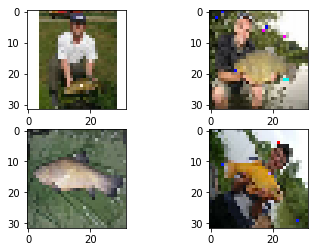

None


In [4]:
// Test a basic dataset that reads and resizes images

let ds:Dataset<Tensor<Float>> = Dataset<StringTensor>(
    elements: sampleTrainFilesTensor).map(resizeImage)
//.batched(5) // For batching

let rows = 2 
let cols = 2 
//plt.figure(figsize: [rows * 3, cols * 3])

for (i, d) in ds.enumerated() {
    print("Processing image \(i)")
    let img = plt.subplot(rows, cols, i + 1)
    img.imshow(d.makeNumpyArray().astype(np.uint8))
    if (i + 1) >= (rows * cols) { break }
}
plt.show()

In [5]:
// Some data structures from 03 minibatch training

// export
public struct DataBatch<Inputs: Differentiable & TensorGroup, Labels: TensorGroup>: TensorGroup {
    public var xb: Inputs
    public var yb: Labels

    public init(xb: Inputs, yb: Labels){
        self.xb = xb
        self.yb = yb
    }
}

// export
public struct DataBunch<Element> where Element: TensorGroup{
    public var train: Dataset<Element>
    public var valid: Dataset<Element>
    
    public init(train: Dataset<Element>, valid: Dataset<Element>) {
        self.train = train
        self.valid = valid
    }
}

In [6]:
// TODO: When TF-421 is fixed, switch this back to Int32 labels.

struct LabeledImagenetteFiles : TensorGroup {
    let labels: Tensor<Float>
    let fnames: StringTensor
}

// e.g., getLabel(from: "imagenette-160/train/n03028079/ILSVRC2012_val_00034021.JPEG")
func getLabel(from fname: String) -> String {
    // let splits = fname.components(separatedBy: "/")
    // let splits = fname.pathComponents
    let splits = fname.split(separator: "/")
    assert(splits.endIndex >= 2, "Filename is not in the relevant form.")
    return String(splits[splits.endIndex - 2])
}

func labeledFiles(fnames: [String]) -> LabeledImagenetteFiles {
   var labels: [String] = []
    for fname in fnames {
        labels.append(getLabel(from: fname))
    }              
    var labelsDict: [String: Float] = [:]
    for (i, label) in Set(labels).enumerated() {
        labelsDict[label] = Float(i)
    }
    let labelIds = labels.map { labelsDict[$0]! }
    return LabeledImagenetteFiles(
        labels: Tensor<Float>(labelIds), 
        fnames: StringTensor(fnames)
    )
}

/* TODO: Enable when we can have pre-built toolchain with Foundation

func labeledFiles(from inputFile: String) -> [LabeledImagenetteInput] {
    do { 
        let fileContents = try String(contentsOfFile: inputFile)
        let fnamesRaw =  fileContents.components(separatedBy: .newlines)
        let fnames = fnamesRaw.filter { !$0.trimmingCharacters(in: .whitespaces).isEmpty }
        return labeledFiles(fnames: fnames)
    } catch {
        print("Error labeling files")
        return []
    }
}
*/

let res = labeledFiles(fnames: sampleValFiles)
print ("Labels: \(res.labels.shape) \n  \(res.labels)")
print ("Fnames: \(res.fnames)")

Labels: TensorShape(dimensions: [15]) 
  [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0]
Fnames: StringTensor(handle: TensorFlow.TensorHandle<Swift.String>)


In [11]:
// TODO: Not tested.
func imagenetteDataBatch(
    _ input: LabeledImagenetteFiles
) -> DataBatch<Tensor<Float>, Tensor<Float>> {
    return DataBatch(
        xb: resizeImage(filename: input.fnames),
        yb: input.labels)
}

func imagenetteDataset(
    _ input: LabeledImagenetteFiles   
) -> Dataset<DataBatch<Tensor<Float>, Tensor<Float>>> {
    return Dataset<LabeledImagenetteFiles>(
        elements: labeledFiles(fnames: sampleValFiles)
    ).map(imagenetteDataBatch)
}

func imagenetteDataBunch(trainFiles: String, valFiles: String, bs: Int = 64
) -> DataBunch<DataBatch<Tensor<Float>, Tensor<Float>>> {
    let trainDS = imagenetteDataset(labeledFiles(fnames: sampleTrainFiles))
    let valDS = imagenetteDataset(labeledFiles(fnames: sampleValFiles))
    return DataBunch(
        train: trainDS.batched(Int64(bs)), 
        valid: valDS.batched(Int64(bs)))
}

let data = imagenetteDataBunch(
    trainFiles: "imagenette-train-files.txt", 
    valFiles: "imagenette-val-files.txt", 
    bs:2)

for (i, d) in data.train.enumerated() {
    print("Processing batch \(i) \(d.xb.shape)")
}

Processing batch 0 TensorShape(dimensions: [2, 32, 32, 3])
Processing batch 1 TensorShape(dimensions: [2, 32, 32, 3])
Processing batch 2 TensorShape(dimensions: [2, 32, 32, 3])
Processing batch 3 TensorShape(dimensions: [2, 32, 32, 3])
Processing batch 4 TensorShape(dimensions: [2, 32, 32, 3])
Processing batch 5 TensorShape(dimensions: [2, 32, 32, 3])
Processing batch 6 TensorShape(dimensions: [2, 32, 32, 3])
Processing batch 7 TensorShape(dimensions: [1, 32, 32, 3])
